# **Seminário Inteligência Artificial MESC - 2024-T4**
#
## Rafael Medeiros e Orlando Nascimento
## Ferramenta: Facebook Prophet
##
### **Tarefas**
* Investigar dados faltantes
* Investigar outliers
* Identificar tendências
* Identificar sazonalidades
* Identificar autocorrelação
### **Métricas de avaliação**
* MAPE
* MSE
* RMSE

In [74]:
# Carregando bibliotecas

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from prophet import Prophet
from prophet.plot import plot_yearly
from prophet.make_holidays import make_holidays_df

In [50]:
# Carregando BD
df = pd.read_csv("../data/water_quality.csv")

In [51]:
### Informações Básicas do Dataset ###

# Dimensões do dataset
print("Verificando o formato do dataset:\n", df.shape)

# Visualizar as primeiras linhas
print("\nVerificando as primeiras linhas do dataset:\n", df.head())

# Verificar os tipos de dados e valores nulos
print("\nVerificando as principais informações do dataset:\n", df.info())

# Resumo estatístico de colunas numéricas
print("\nVerificando o resumo das estatísticas quantitativas do dataset:\n",df.describe())

# Verificar a lista de colunas
print("\nVerificando as colunas do dataset:\n", df.columns)

Verificando o formato do dataset:
 (2373, 15)

Verificando as primeiras linhas do dataset:
          Data  Turbidity        pH  Alkalinity  DissolvedOxygen  \
0  2018-01-01   7.367186  6.845486   25.788530         6.715897   
1  2018-01-02  35.755183  6.807069   19.943425         5.233228   
2  2018-01-03   9.341618  6.906234   19.910010         5.856647   
3  2018-01-04  16.105204  6.817615   20.249162         6.004393   
4  2018-01-05  16.531502  7.045985   18.217803         6.050563   

   RainAccumulation1D  RainAccumulation2D  RainAccumulation3D  \
0            0.001155            2.794847            2.318741   
1            0.001092            0.255247            0.718060   
2            0.012032            0.013785            0.029363   
3            0.002139            1.929273            0.788018   
4            0.002479            1.077661            0.135524   

   RainAccumulation4D  RainAccumulation5D  RainAccumulation6D  \
0            1.460683            9.169686        

In [52]:
# ajustando o tipo de dados

df["Data"] = pd.to_datetime(df["Data"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2373 entries, 0 to 2372
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Data                 2373 non-null   datetime64[ns]
 1   Turbidity            2373 non-null   float64       
 2   pH                   2373 non-null   float64       
 3   Alkalinity           2373 non-null   float64       
 4   DissolvedOxygen      2373 non-null   float64       
 5   RainAccumulation1D   2373 non-null   float64       
 6   RainAccumulation2D   2373 non-null   float64       
 7   RainAccumulation3D   2373 non-null   float64       
 8   RainAccumulation4D   2373 non-null   float64       
 9   RainAccumulation5D   2373 non-null   float64       
 10  RainAccumulation6D   2373 non-null   float64       
 11  RainAccumulation7D   2373 non-null   float64       
 12  RainAccumulation15D  2373 non-null   float64       
 13  RainAccumulation30D  2373 non-nul

In [53]:
# Criar uma cópia para verificar descontinuidades
df_copy = df.copy()
df_copy["diff_days"] = df_copy["Data"].diff().dt.days  # Diferença entre datas em dias
descontinuidades = df_copy[df_copy["diff_days"] > 1]  # Identificar onde há gaps

# Verificar se há descontinuidade e exibir o resultado
if not descontinuidades.empty:
    print("Há descontinuidades na série temporal. Detalhes:")
    print(descontinuidades[["data", "diff_days"]])  # Exibir apenas colunas relevantes
else:
    print("Não há descontinuidades na série temporal.")

Não há descontinuidades na série temporal.


## Embasamento matemático do FB Prophet
O modelo matemático do FB Prophet é representado pela equação abaixo

**y(t) = g(t) + s(t) + h(t) + $\epsilon_t$**

onde:
* **g(t)** é o componente de crescimento, ou a tendência geral, que não é periódica
* **s(t)** é o componente de sazonalidade, a somatória de todos os componentes periódicos
* **h(t)** é o componene de feriado, representando todos os eventos especiais
* **$\epsilon_t$** é a componente de erro



### Componente de crescimento linear
**g(t) = (k + $\alpha(t)^T\delta$)t + (m + $\alpha(t)^T\gamma$)**
onde:
* **k** é a taxa de crescimento, a inclinação da reta
* **$\alpha(t)$** é o vetor que indica a localização das mudanças na inclinação da reta
* **$\delta$** é o vetor de ajuste da inclinação da reta
* **m** parâmetro de offset
* **$\gamma$** é o vetor de ajuste do offset

A equação acima tem similaridades com a equação da reta **y = mx + b**. 

A grande diferença está no componente **(k + $\alpha(t)^T\delta$)** indicando que a inclinação da reta é uma função de **t**.

Devido à essa propriedade, inclinação da reta **k** está em conjunto com o termo  **$\alpha(t)^T\delta$**.

O **$\delta$** é o vetor de ajuste da taxa da inclinação da reta, onde **$\delta_j$** é a mudança na inclinação ocorrida o tempo **$s_j$**.

O vetor **$\alpha(t)$** indica a localização das mudanças, conforme abaixo:

$a_j(t) = \begin{cases} 
1, & \text{se } t \geq s_j \\
0, & \text{para todos outros casos}
\end{cases}$

Ou seja, a inclinação é constante, mas permite que ajustes ocorram.

Já o segundo componete da equação, **(m + $\alpha(t)^T\gamma$)**, ajusta a reta com um offset adequado para que não haja descontinuidade quando ocorrer uma mudança de inclinação. 

### Componente de crescimento logístico
Para problema de regressão logística, a seguinte equação é utilizada:

$g(t) = \frac{C}{1 + \exp(-k(t - m))}$

onde:
* C é assíntota da curva logística, que também pode variar com o tempo, conforme a configuração do Prophet.

Permitindo se sejam feitos os mesmos ajustes na equação da regressão linear, que foram realizados na inclinação e offset, a regressão logística fica dessa forma:

$g(t) = \frac{C}{1 + \exp(-(k + \alpha(t)^T\delta)(t - (m + \alpha(t)^T\gamma)))}$

### Sazonalidade
Para sazonalidade, o Prophet usa a modelagem através de séries de Fourier. A modelagem é feita da seguinte forma:

$$
s(t) = \sum_{n=1}^N \left( a_n \cos\left(\frac{2\pi n t}{P}\right) + b_n \sin\left(\frac{2\pi n t}{P}\right) \right)
$$


### Feriados
É possível ajustar o Prophet com eventos especiais para prover maior robustez de previsibilidade ao modelo.

O Prophet estima os desvios na tendência e sazonalidade pelas datas passadas e aplica as mesmas mudanças a data futuras.

A modelagem é feita por meio da equação:

$$
h(t) = Z(t)k
$$

onde
$$
Z(t) = [1(t \in D_1), ..., 1(t \in D_L)]
$$
é uma matriz de regressores com os dados sobre os feriados e $k$ é um vetor com as mudanças nas previsõe relativas aos feriados. 


In [54]:
# dividindo em dataframes menores para cada atributo
# a nomenclatura das variáveis segue o padrão:
# df_column

for column in df.columns[1:]:  # Ignorar a primeira coluna ("data")
    globals()[f"df_{column}"] = df[["Data", column]]

In [55]:
# testando as funcionalidades do Prophet com o atributo "Turbidity"

df_Turbidity.columns = ['ds', 'y']

df_Turbidity.head()

,ds,y
0,2018-01-01,7.367186
1,2018-01-02,35.755183
2,2018-01-03,9.341618
3,2018-01-04,16.105204
4,2018-01-05,16.531502


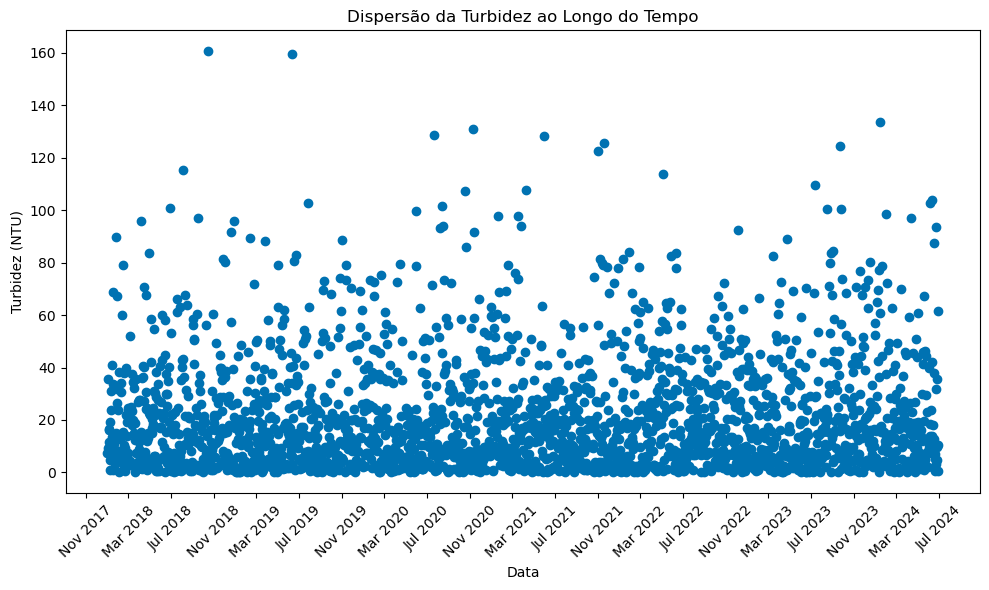

In [56]:
# Visualizando o dataset em gráfico

plt.figure(figsize=(10, 6))
plt.scatter(x=df_Turbidity['ds'], y=df_Turbidity['y'], c='#0072B2')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Data')
plt.ylabel('Turbidez (NTU)')
plt.title('Dispersão da Turbidez ao Longo do Tempo')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:52 - cmdstanpy - INFO - Chain [1] done processing


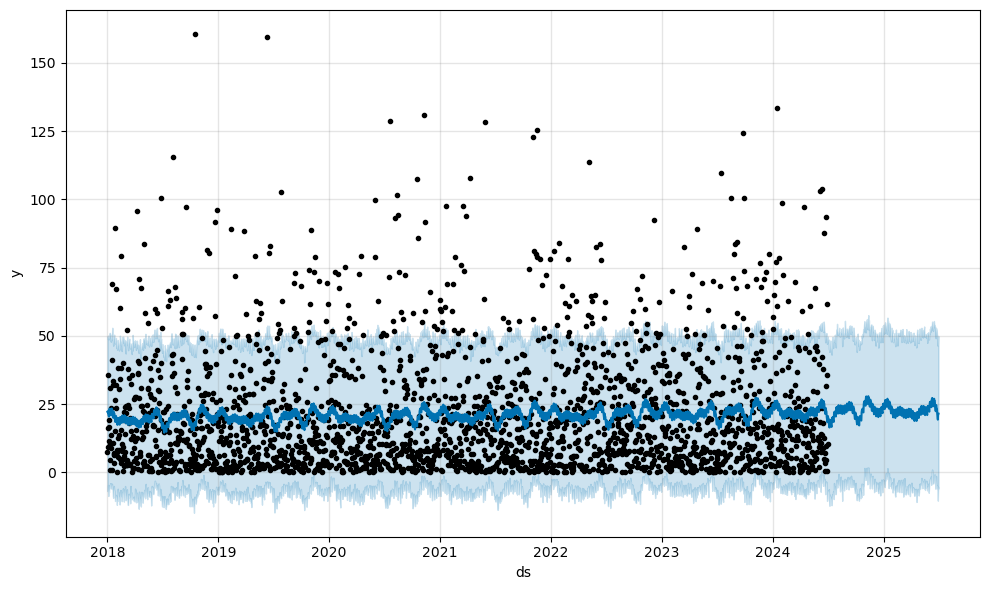

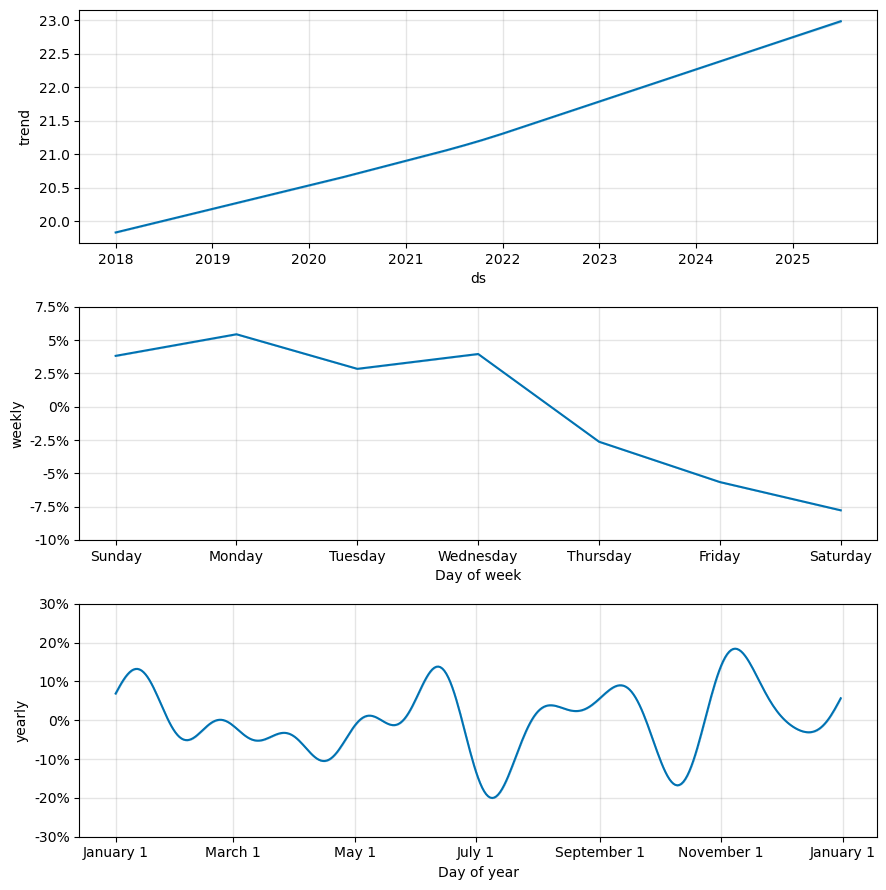

In [57]:
# testando o gráfico de predição

model = Prophet(seasonality_mode='multiplicative')
model.fit(df_Turbidity)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()
fig2 = model.plot_components(forecast)
plt.show()

## Analisando a sazonalidade dos dados

17:35:29 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing


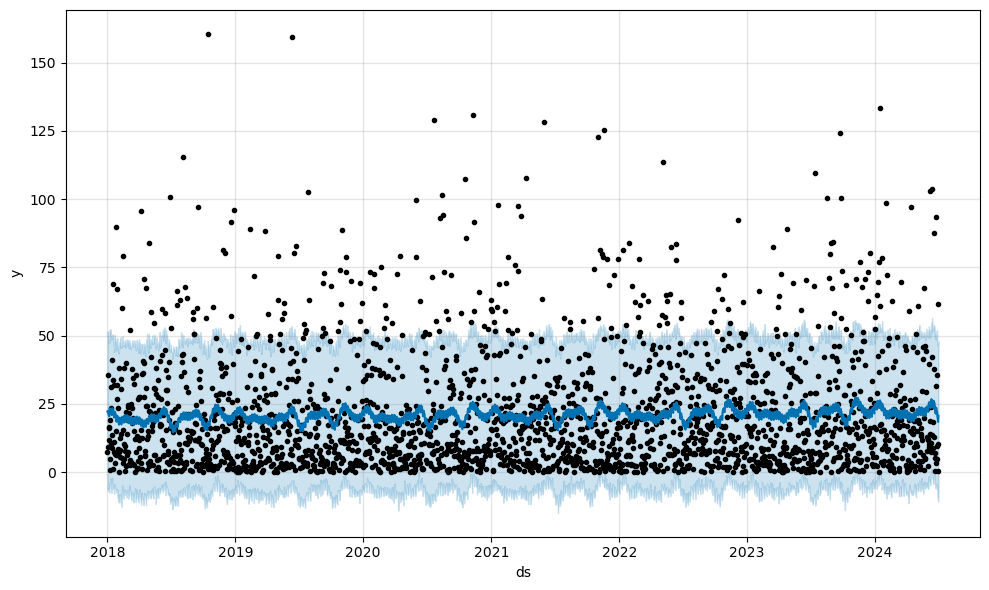

In [58]:
# Testando sazonalidade multiplicativa

model_m = Prophet(seasonality_mode='multiplicative') # NÃO ESQUEÇA DE AJUSTA O PARÂMETRO DE AJUSTE DE ORDEM: ", yearly_seasonality=4"
model_m.fit(df_Turbidity)
forecast_m = model_m.predict()
fig_m = model_m.plot(forecast_m)
plt.show()

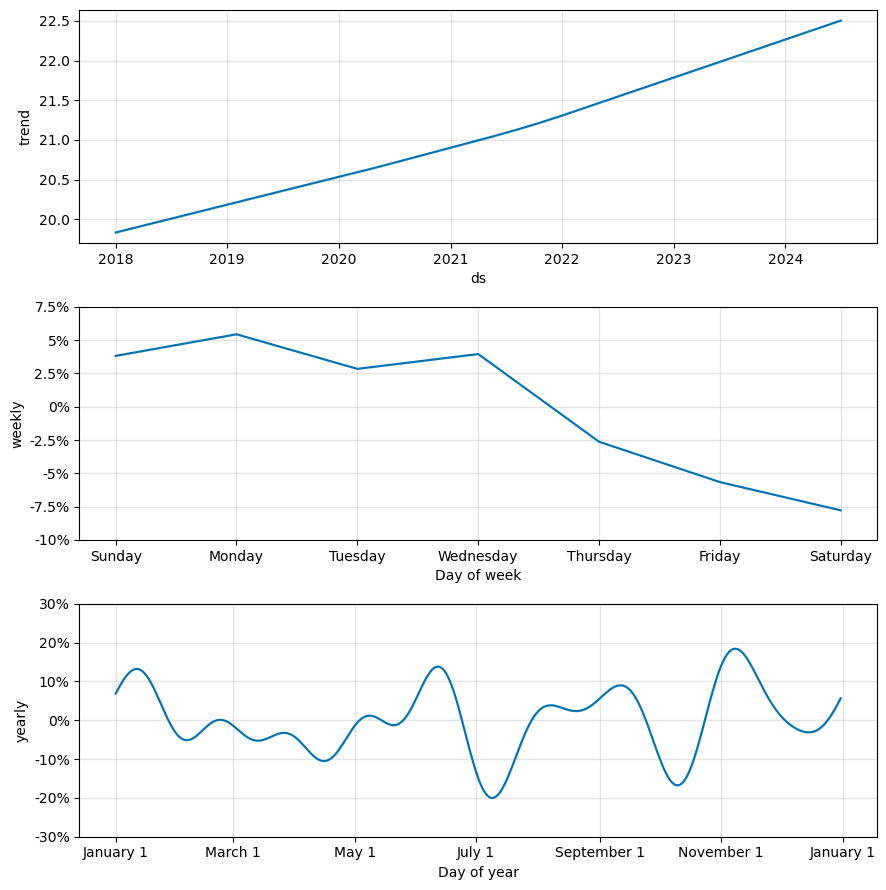

In [60]:
# Analisando a tendência da sazonalidade multiplicativa

fig_m2 = model_m.plot_components(forecast_m)
plt.show()

### Análises iniciais
#### **tendência no período analisado**
Na tendência anual, percebe-se um crescimento quase linear ao longo dos anos com uma pequena inflexão da inclinação da curva para cima entre 2021 e 2022.

#### **tendência semanal**
Há um pico de 5% em relação a tendência no primeiro dia útil da semana, com o início da queda da tendência a partir da quarta-feira.

No sábado, a tendência atinge seu valor mais baixo, em torno de 7% menor que a tendência.

#### **tendência anual**
Observa-se uma variação sazonal ao longo dos meses, sendo mais estável entre os perídos de fevereiro a abril.

A partir de março, há uma oscilação mais visível, com uma tendência de crescimento da tendência anual a partir de julho até dezembro.

Os dados oscilam bastante a partir de fevereiro, com um pico em junho.

Essa característica pode denotar que a ordem a série está muito alta e a análise pode ter overfitting.

### Controlando a sazonalidade com a ordem de uma Série de Fourier

Controlar a ordem de uma Séries de Fourier é similar ao controlar o grau de uma função linear.

Ao controlar a ordem, ajusta-se o somatório de curvas senoidais que compõe a curva final.

Quanto maior a ordem, mais a curva vai se ajustar aos dados observados, mas também aumenta o risco de overfitting.

Por default, o Prophet ajusta a ordem das sazonalidades conforme abaixo:
* Anual: ordem 10
* Semanal: ordem 3
* Diária: ordem 4

In [66]:
# Adicionando feriados nacionais para o Brasil

model.add_country_holidays(country_name='BR')

Exception: Country holidays must be added prior to model fitting.

In [ ]:
# instanciando um modelo variando a ordem da sazonalidade anual

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=5)

model.add_country_holidays(country_name='BR') # Adicionando efeitos feriados nacionais para o Brasil

model.fit(df_Turbidity)

17:40:31 - cmdstanpy - INFO - Chain [1] start processing
17:40:32 - cmdstanpy - INFO - Chain [1] done processing


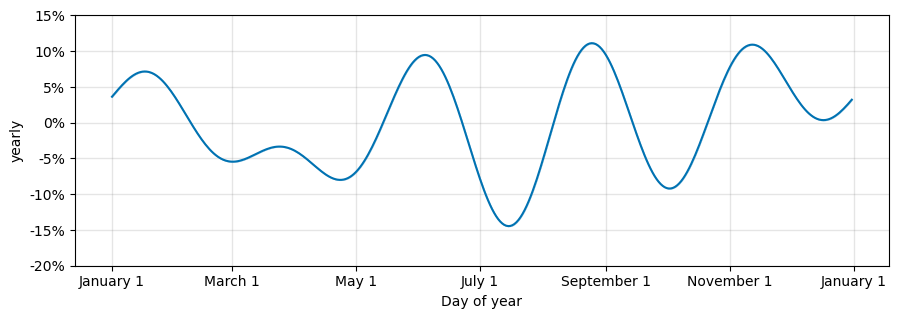

In [62]:
fig3 = plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

Com a variação da ordem de Fourier de 10 para 5, a curva ficou mais suave e menos sensível a ruídos

## Regularizando Sazonalidade

In [63]:
# Regularizando a sazonalidade global (gs)

model_gs = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=5,
                seasonality_prior_scale=.01)

17:36:54 - cmdstanpy - INFO - Chain [1] start processing
17:36:54 - cmdstanpy - INFO - Chain [1] done processing


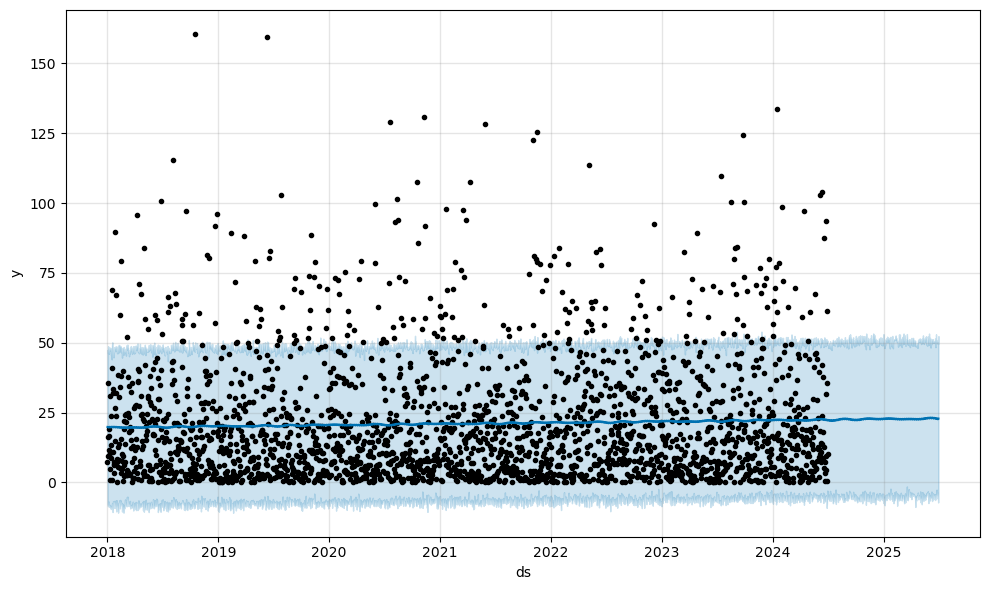

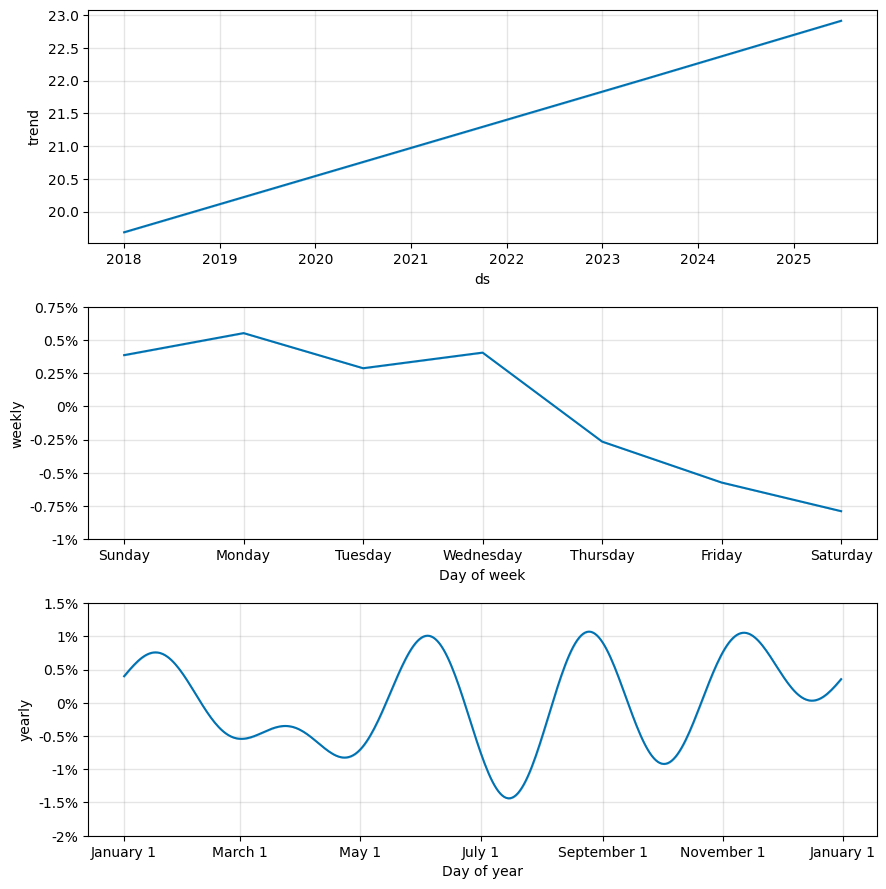

In [64]:
model_gs.fit(df_Turbidity)
future = model_gs.make_future_dataframe(periods=365)
forecast = model_gs.predict(future)

fig4 = model_gs.plot(forecast)
plt.show()

fig5 = model_gs.plot_components(forecast)
plt.show()

## Efeitos de feriados e eventos especiais

# **ATENÇÃO:**
# Não parece fazer muito sentido incluir feriados na modelagem.
# Estamos trabalhando com dados de fenômenos naturais que não são afetados pela sazonalidade de feriados.

In [ ]:
'''
# Adicionando feriados nacionais para o Brasil

model.add_country_holidays(country_name='BR')

##########
OBS: JÁ ADICIONADO ANTERIORMENTE. 
O MÉTODO PARA INCLUIR OS FERIADOS NACIONAIS .add_country_holidays(country_name='BR') DEVE SER FEITO ANTES DO MÉTODO .fit(df)
##########

'''

Exception: Country holidays must be added prior to model fitting.

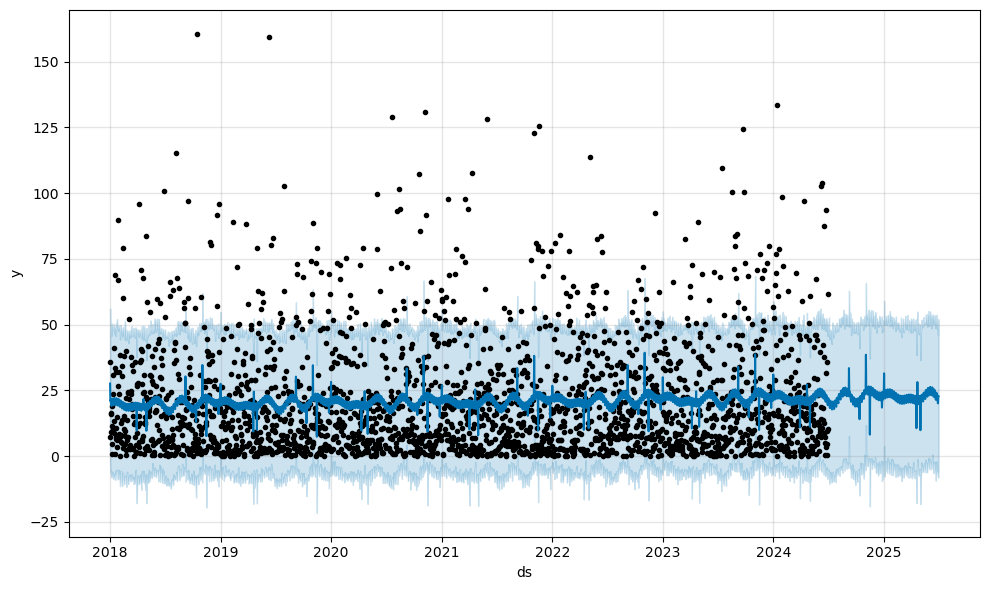

In [ ]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

# Perceba alguns picos ao longo dos dados devido ao efeito dos feriados

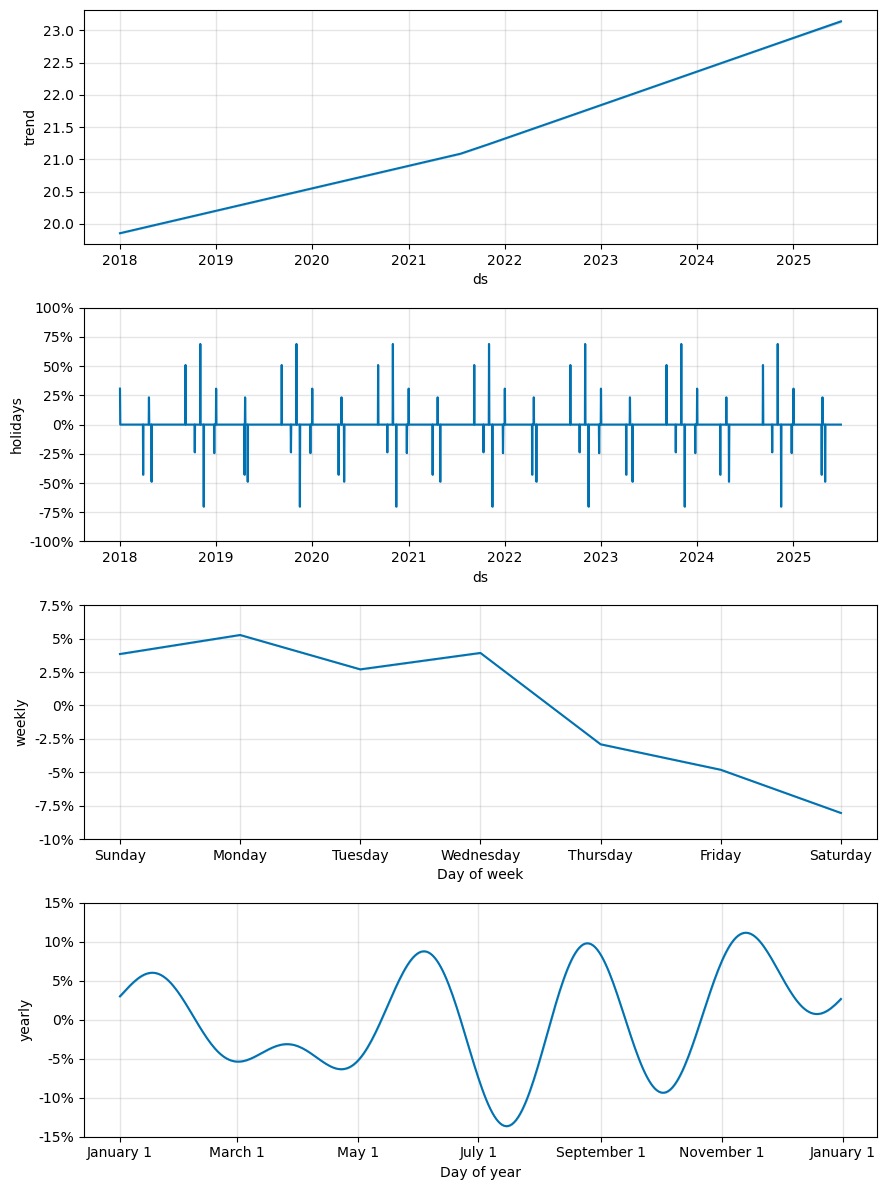

In [ ]:
# Agora separandos os componentes para ver melhor os efeitos dos feriados

fig_comp_holidays = model.plot_components(forecast)
plt.show()

In [71]:
# Verificando os feriados incluídos no modelo

model.train_holiday_names

0                      Confraternização Universal
1                               Sexta-feira Santa
2                                      Tiradentes
3                              Dia do Trabalhador
4                         Independência do Brasil
5                         Nossa Senhora Aparecida
6                                         Finados
7                        Proclamação da República
8                                           Natal
9    Dia Nacional de Zumbi e da Consciência Negra
dtype: object

In [ ]:
# Definindo uma função para analisar os efeitos de cada feriado
def first_non_zero(fcst, holiday):
    non_zero_values = fcst[fcst[holiday] != 0][holiday].values
    if len(non_zero_values) > 0:
        return non_zero_values[0]
    else:
        return None  # ou algum valor padrão, como 0 ou np.nan

# Gerando o DataFrame de efeitos dos feriados
holiday_effects = pd.DataFrame({
    'holiday': model.train_holiday_names,
    'effect': [first_non_zero(forecast, holiday) for holiday in model.train_holiday_names]
})

# Exibe o DataFrame
print(holiday_effects)


                                        holiday    effect
0                    Confraternização Universal  0.307434
1                             Sexta-feira Santa -0.429589
2                                    Tiradentes  0.233034
3                            Dia do Trabalhador -0.489106
4                       Independência do Brasil  0.509382
5                       Nossa Senhora Aparecida -0.237512
6                                       Finados  0.689253
7                      Proclamação da República -0.702547
8                                         Natal -0.244484
9  Dia Nacional de Zumbi e da Consciência Negra       NaN


Os efeitos dos feriados tem um impacto significativo nos modelos conforme analisado anteriormente

O feriado de Independência do Brasil tem um crescimento de 50% em relação à previsão.

O feriado da Proclamação da República tem um decrescimo de 70% em relação à previsão.

O feriado da Consciência Negra não apresenta um impacto significativo e pode ser retirado do modelo.

In [75]:
# Adicionando feriados regionais 

year_list = df_Turbidity['ds'].dt.year.unique().tolist()
# Identifica o ano final, como um inteiro, e aumenta em uma unidade
year_list.append(year_list[-1] + 1)
holidays = make_holidays_df(year_list=year_list,
                            country='BR',
                            state='RJ')

In [ ]:
# Verificando a lista de feriados

holidays.head(10)


# NÃO HÁ FERIADOS REGIONAIS LISTADOS PARA O RJ. NÃO VAMOS USAR ESSA FUNCIONALIDADE.

,ds,holiday
0,2018-01-01,Confraternização Universal
1,2018-03-30,Sexta-feira Santa
2,2018-04-21,Tiradentes
3,2018-05-01,Dia do Trabalhador
4,2018-09-07,Independência do Brasil
5,2018-10-12,Nossa Senhora Aparecida
6,2018-11-02,Finados
7,2018-11-15,Proclamação da República
8,2018-12-25,Natal
9,2019-01-01,Confraternização Universal


In [81]:
model.train_holiday_names

0                      Confraternização Universal
1                               Sexta-feira Santa
2                                      Tiradentes
3                              Dia do Trabalhador
4                         Independência do Brasil
5                         Nossa Senhora Aparecida
6                                         Finados
7                        Proclamação da República
8                                           Natal
9    Dia Nacional de Zumbi e da Consciência Negra
dtype: object